In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import datetime as dt
import pytz# add a coordinate with LocalTime for Plotting
import xarray as xr
import geopandas as gpd
import fiona
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'
from soslib import funcs
from dataretrieval import nwis
import pyet

### Download data from Tilden's tower and filter for dates of interest

In [116]:
df_tilden = pd.read_parquet('../../data/tilden_tower/tilden_fluxdata_consolidated.parquet')
df_tilden = df_tilden.set_index('date')

In [117]:
# Get data for november 10th through 16th when snow appeared and disappeared
df_tilden_1110_1116_3m = df_tilden[(df_tilden.index > dt.datetime(2021,11,10)) & 
                                    (df_tilden.index < dt.datetime(2021,11,16)) & 
                                    (df_tilden['height']==3) &
                                    (df_tilden['e']<=df_tilden['es'])
                                    ].replace(-999.0, np.nan).resample('1H').mean()
df_tilden_1110_1116_10m = df_tilden[(df_tilden.index > dt.datetime(2021,11,10)) & 
                                    (df_tilden.index < dt.datetime(2021,11,16)) & 
                                    (df_tilden['height']==10)&
                                    (df_tilden['e']<=df_tilden['es'])
                                    ].replace(-999.0, np.nan).resample('1H').mean()

# Get data for november 24 to 30 when snow appeared and disappeared
df_tilden_1124_1130_3m = df_tilden[(df_tilden.index > dt.datetime(2021,11,24)) & 
                                    (df_tilden.index < dt.datetime(2021,11,30)) & 
                                    (df_tilden['height']==3)&
                                    (df_tilden['e']<=df_tilden['es'])
                                    ].replace(-999.0, np.nan).resample('1H').mean()
df_tilden_1124_1130_10m = df_tilden[(df_tilden.index > dt.datetime(2021,11,24)) & 
                                    (df_tilden.index < dt.datetime(2021,11,30)) & 
                                    (df_tilden['height']==10)&
                                    (df_tilden['e']<=df_tilden['es'])
                                    ].replace(-999.0, np.nan).resample('1H').mean()




### Download relevant SAIL SEBS data with soil moisture

In [118]:
# Gather soil moisture data 
product= 'gucsebsS3.b1'
username = 'dlhogan@uw.edu'
token = '7f1c805e6ae94c21'
start_1 = '2021-11-10'
end_1 = '2021-11-16'
start_2 = '2021-11-24'
end_2 = '2021-11-30'

In [119]:
def add_local_time(ds):
    time_utc = ds['time'].to_index().tz_localize(pytz.UTC)
    us_mtn = pytz.timezone('US/Mountain')
    tz_corrected = time_utc.tz_convert(us_mtn).tz_localize(None)
    local_da=xr.DataArray.from_series(tz_corrected)
    ds.coords.update({'local_time':tz_corrected})
    return ds

In [120]:
ds_sebs_1110_1116 = funcs.get_sail_data(username,token,product,start_1,end_1)
ds_sebs_1110_1116 = add_local_time(ds_sebs_1110_1116)

ds_sebs_1124_1130 = funcs.get_sail_data(username,token,product,start_2,end_2)
ds_sebs_1124_1130 = add_local_time(ds_sebs_1124_1130)

[DOWNLOADING] gucsebsS3.b1.20211110.000000.cdf
                             
[DOWNLOADING] gucsebsS3.b1.20211111.000000.cdf
                             
[DOWNLOADING] gucsebsS3.b1.20211112.000000.cdf
                             
[DOWNLOADING] gucsebsS3.b1.20211113.000000.cdf
                             
[DOWNLOADING] gucsebsS3.b1.20211114.000000.cdf
                             
[DOWNLOADING] gucsebsS3.b1.20211115.000000.cdf
                             
[DOWNLOADING] gucsebsS3.b1.20211116.000000.cdf
                             
[DOWNLOADING] gucsebsS3.b1.20211124.000000.cdf
                             
[DOWNLOADING] gucsebsS3.b1.20211125.000000.cdf
                             
[DOWNLOADING] gucsebsS3.b1.20211126.000000.cdf
                             
[DOWNLOADING] gucsebsS3.b1.20211127.000000.cdf
                             
[DOWNLOADING] gucsebsS3.b1.20211128.000000.cdf
                             
[DOWNLOADING] gucsebsS3.b1.20211129.000000.cdf
                             

In [121]:
ds_ecor_1110_1116 = funcs.get_sail_data(username,token,'guc30ecorS3.b1',start_1,end_1)
ds_sebs_1110_1116 = add_local_time(ds_sebs_1110_1116)

[DOWNLOADING] guc30ecorS3.b1.20211110.000000.cdf
                             
[DOWNLOADING] guc30ecorS3.b1.20211111.000000.cdf
                             
[DOWNLOADING] guc30ecorS3.b1.20211112.000000.cdf
                             
[DOWNLOADING] guc30ecorS3.b1.20211113.000000.cdf
                             
[DOWNLOADING] guc30ecorS3.b1.20211114.000000.cdf
                             
[DOWNLOADING] guc30ecorS3.b1.20211115.000000.cdf
                             
[DOWNLOADING] guc30ecorS3.b1.20211116.000000.cdf
                             


### Grab ecor estimate for sublimation values

In [122]:
ecor_sublimation = ds_ecor_1110_1116['lv_e'] / ds_ecor_1110_1116['lv']
ecor_sublimation = ecor_sublimation.resample(time='1H').mean() * 3600
ecor_sublimation = add_local_time(ecor_sublimation)

### Download RADSYS data for first snow-on/snow-off period

In [123]:
radsys_ds = funcs.get_daily_radsys_data('2021-11-10', '2021-11-16')
dw_solar_hourly = radsys_ds.where(radsys_ds['dw_solar_qc']==0).resample(time='1H').mean()
dw_solar_hourly = add_local_time(dw_solar_hourly)

https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp21314.dat
https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp21315.dat
https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp21316.dat
https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp21317.dat
https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp21318.dat
https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp21319.dat
https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp21320.dat


### Get East River flow data and extrapolate the pumphouse flow rate

In [125]:
er_1110_1116_df = nwis.get_iv(sites=['09112200'], start='2021-11-10',end='2021-11-16')[0]
idx  = er_1110_1116_df.index.tz_localize(None)
er_1110_1116_df.index = idx
er_1124_1130_df = nwis.get_iv(sites=['09112200'], start='2021-11-24',end='2021-11-30')[0]
idx  = er_1124_1130_df.index.tz_localize(None)
er_1124_1130_df.index = idx

In [ ]:
## Get basin area to convert streamflow to mm/day/m2
subbasins_gdf = gpd.read_file('../multisite/polygons/subbasins.kmz')
east_river_poly = gpd.read_file('../multisite/polygons/east_polygon.json')
ph_area = subbasins_gdf.to_crs(east_river_poly.crs).unary_union.area


0.40521843324670365

In [326]:
er_1110_1116_q = er_1110_1116_df['00060']/35.315
slope = 0.23090890597826277
intercept = -0.07313471407001249

er_to_ph_q = slope*er_1110_1116_q + intercept 
er_to_ph_q_mm = er_to_ph_q * 3600 *24 * 1000 / ph_area

### Looking at period November 10 to 16. Snow fell first on the 10th and was gone  by the 16th. Temperature

Text(0, 0.5, 'Soil Moisture (%)')

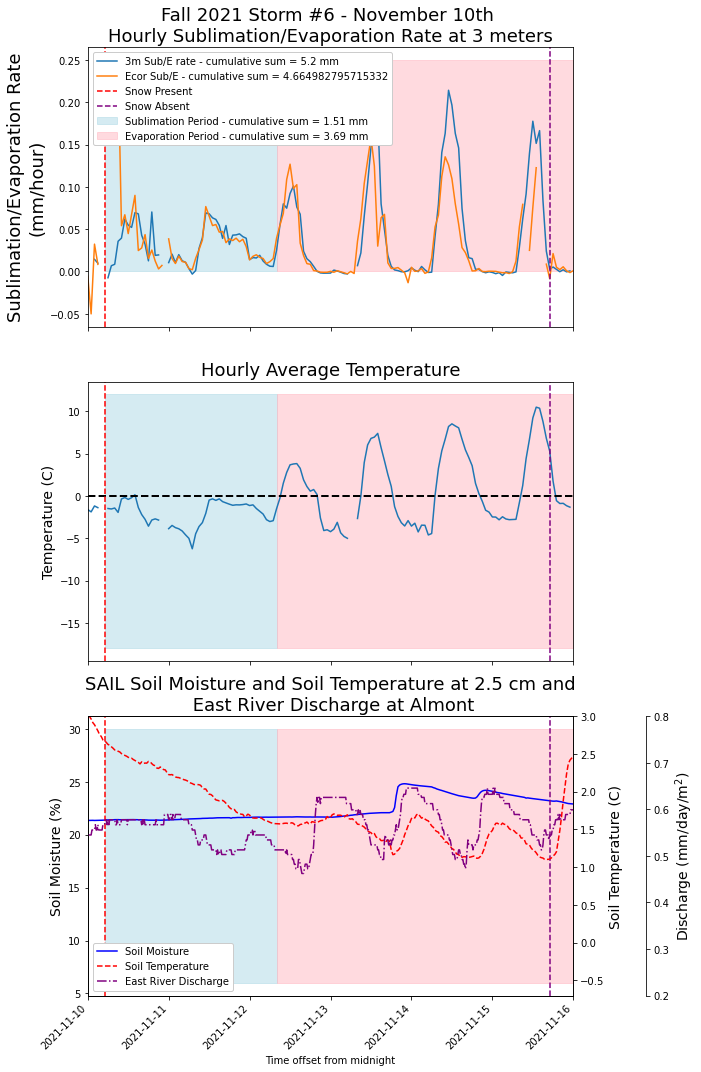

In [339]:
# Get latent heat of vaporization
Ls = 2.834e6
E_3m = df_tilden_1110_1116_3m['LE']/Ls * 3600 
E_10m = df_tilden_1110_1116_10m['LE']/Ls * 3600

fig, axs = plt.subplots(3, figsize=(10,15), facecolor='white', tight_layout=True,sharex=True)

# Plots for sublimation/evaporation rate
axs[0].plot(df_tilden_1110_1116_3m.index, E_3m, label=f'3m Sub/E rate - cumulative sum = {round(E_3m.sum(),2)} mm')
axs[0].plot(ecor_sublimation.local_time, ecor_sublimation, label=f'Ecor Sub/E - cumulative sum = {(ecor_sublimation.sum())}')

# Plots for aur tenoerature and downwelling solar radiation
axs[1].plot(df_tilden_1110_1116_3m.index, df_tilden_1110_1116_3m['Tair']-273.15, label='3m Temperature')
axs[1].axhline(0, ls='--', color='k', lw=2)

# Plots for soil moisture and soil temperature and Discharge
ax2_2 = axs[2].twinx()
ds_sebs_1110_1116['soil_temp_3'].plot(ax=ax2_2, label='Soil Temperautre', ls='--', color='r')
ds_sebs_1110_1116['soil_moisture_3'].where(ds_sebs_1110_1116['qc_soil_moisture_3']==0).plot(ax=axs[2], label='Soil Moisture',color='blue')
ax2_2.set_ylim(-0.7,3)
ax2_2.set_ylabel('Soil Temperature (C)', size=14)

ax2_3 = axs[2].twinx()
ax2_3.spines.right.set_position(("axes", 1.15))
ax2_3.plot(er_to_ph_q_mm.index,er_to_ph_q_mm, ls='-.', color='purple')
ax2_3.set_ylabel('Discharge (mm/day/m$^2$)', size=14)
ax2_3.set_ylim(.20,.80)

axs[2].plot([],[],label='Soil Temperature', ls='--', color='r')
axs[2].plot([],[],label='East River Discharge', ls='-.', color='purple')
axs[2].legend(loc='lower left', framealpha=1)

y_ranges = [[0,0.25],[-18,12],[6,30]]
for i,ax in enumerate(axs):
    ax.axvline(dt.datetime(2021,11,10,5), label='Snow Present', ls='--', color='red')
    ax.axvline(dt.datetime(2021,11,15,17), label='Snow Absent', ls='--', color='purple')
    ax.fill_betweenx(y_ranges[i], dt.datetime(2021,11,10,5),
                                  dt.datetime(2021,11,12,8), 
                                  label=f'Sublimation Period - cumulative sum = {round(E_3m.loc[dt.datetime(2021,11,10,5):dt.datetime(2021,11,12,8)].sum(),2)} mm', 
                                  alpha=0.5, 
                                  color='lightblue')
    ax.fill_betweenx(y_ranges[i], dt.datetime(2021,11,12,8),
                                  dt.datetime(2021,11,16,0), 
                                  label=f'Evaporation Period - cumulative sum = {round(E_3m.loc[dt.datetime(2021,11,12,8):dt.datetime(2021,11,16,0)].sum(),2)} mm', 
                                  alpha=0.5,
                                  color='lightpink')
    ax.tick_params(axis='x', rotation=45)
    if i ==0:
        ax.legend(framealpha=1)
    ax.set_xlim(dt.datetime(2021,11,10), dt.datetime(2021,11,16,0))

axs[0].set_ylabel('Sublimation/Evaporation Rate\n(mm/hour)', size=18)
axs[0].set_title('Fall 2021 Storm #6 - November 10th \nHourly Sublimation/Evaporation Rate at 3 meters', size=18)

axs[1].set_title('Hourly Average Temperature', size=18)
axs[1].set_ylabel('Temperature (C)', size=14)

axs[2].set_title('SAIL Soil Moisture and Soil Temperature at 2.5 cm and\n East River Discharge at Almont', size=18)
axs[2].set_ylabel('Soil Moisture (%)', size=14)

### Plot sebs soil moisture to see what the data looks like. Appears soil moisture probe 3 is the smoothest, but unsure if this is the one to use

In [304]:
hrs = ['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23']
tmp = []
dates = [314,315,316,317]
for date in dates:
    for hr in hrs:
        tmp.append(pd.read_csv(f'https://downloads.psl.noaa.gov/psd2/data/realtime/DisdrometerParsivel/Stats/kps/2021/{date}/kps21{date}{hr}_stats.txt', sep='\s+', skiprows=2))

In [305]:
distrometer_df = pd.concat(tmp)
distrometer_df = distrometer_df.set_index('MM:SS:mmm')

In [307]:
rr = distrometer_df['Rate(mm/h)']
rr[rr<0]=np.nan
rr.sum()/30




A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


334.83033333333333

In [322]:
density_profile = pd.read_xml(r"C:\Users\dlhogan\Downloads\KP11-21-Jan.xml")['profile'][8]
depths = [float(j[0])/10 for j in [i.split(":") for i in tmp_profile.split(';')]]
density = [float(j[1]) for j in [i.split(":") for i in tmp_profile.split(';')]]

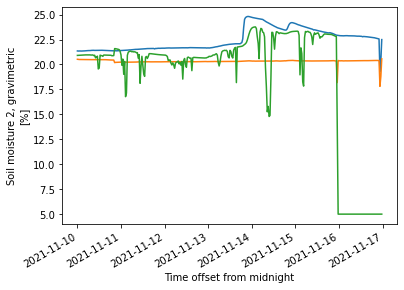

In [164]:
ds_sebs_1110_1116['soil_moisture_1'].plot()
ds_sebs_1110_1116['soil_moisture_2'].plot()
ds_sebs_1110_1116['soil_moisture_3'].plot()

### Convert radsys to hourly for PET calculation

In [193]:
radsys_ds_hourly = radsys_ds.resample(time='1H').mean().sel(time=df_tilden_1110_1116_3m.index)
radsys_ds_daily = radsys_ds_hourly.resample(time='1D').mean()

In [253]:
pot_et_hourly = pyet.pm(tmean = df_tilden_1110_1116_3m.Tair-273.15,
        wind = df_tilden_1110_1116_10m.wind_speed,
        rh=df_tilden_1110_1116_10m.RH,
        rn=radsys_ds_hourly.TotalNet * 24*3600/1e6,
        elevation=2860).interpolate(method='linear')


### Plot potential ET versus calculated ET from sonic

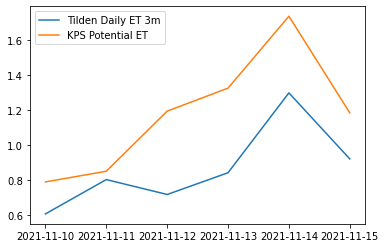

In [254]:
daily_potential_ET = pot_et_hourly[pot_et_hourly>=0].groupby(pot_et_hourly[pot_et_hourly>=0].index.date).mean()
tilden_E_3m = E_3m.groupby(E_3m.index.date).sum()

tilden_E_3m.plot(label='Tilden Daily ET 3m')
daily_potential_ET.plot(label='KPS Potential ET')
plt.legend()

### Look at this early november event for soil moisture signal

In [234]:
# Early November soil moisture
sm_max = ds_sebs_1110_1116['soil_moisture_3'].where(ds_sebs_1110_1116['qc_soil_moisture_3']==0).sel(time=slice('2021-11-13 00','2021-11-14')).max()
sm_min = ds_sebs_1110_1116['soil_moisture_3'].where(ds_sebs_1110_1116['qc_soil_moisture_3']==0).sel(time=slice('2021-11-13 00','2021-11-14')).min()
sm_diff = sm_max - sm_min

rho_soil = np.mean([1.98,0.95]) # kg_soil/m3

rho_w = 1000 # kg_w/m3
V_soil = 0.025 # m3
M_soil = rho_soil * V_soil # kg_soil


delta_mw = M_soil * sm_diff # kg_soil * kg_water/kg_soil
delta_soil_water = delta_mw / rho_w * 1000 # kg_water * m3/1000 kg_w * 1000 mm/m * 1m2
delta_soil_water

<xarray.DataArray 'soil_moisture_3' ()>
array(0.11580164)

In [144]:
d_E_mm = E_3m.loc[dt.datetime(2021,11,13,0):dt.datetime(2021,11,14,0)].sum()
d_E_mm # mm

0.8482357092448836

### Plot signal of ET, Q and soil moisture

Text(0, 0.5, 'mm of water per m$^2$')

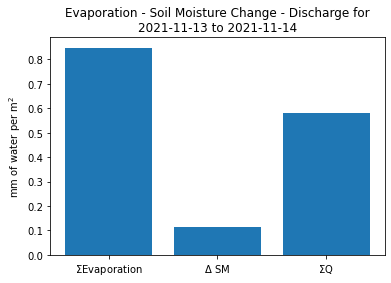

In [332]:
plt.bar(['$\Sigma$Evaporation','$\Delta$ SM','$\Sigma$Q'],[d_E_mm, delta_soil_water, er_to_ph_q_mm.loc[dt.date(2021,11,13):dt.date(2021,11,14)].mean()])
plt.title('Evaporation - Soil Moisture Change - Discharge for\n2021-11-13 to 2021-11-14')
plt.ylabel('mm of water per m$^2$')

### Second Event Plots

In [333]:
er_1124_1130_q = er_1124_1130_df['00060']/35.315
slope = 0.23090890597826277
intercept = -0.07313471407001249

er_to_ph_q_2 = slope*er_1124_1130_q + intercept 
er_to_ph_q_2_mm = er_to_ph_q_2 * 3600 *24 * 1000 / ph_area

In [ ]:
radsys_ds_2 = funcs.get_daily_radsys_data('2021-11-24', '2021-11-30')

https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp21328.dat
https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp21329.dat
https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp21330.dat
https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp21331.dat
https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp21332.dat
https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp21333.dat
https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp21334.dat


Text(0, 0.5, 'Soil Moisture (%)')

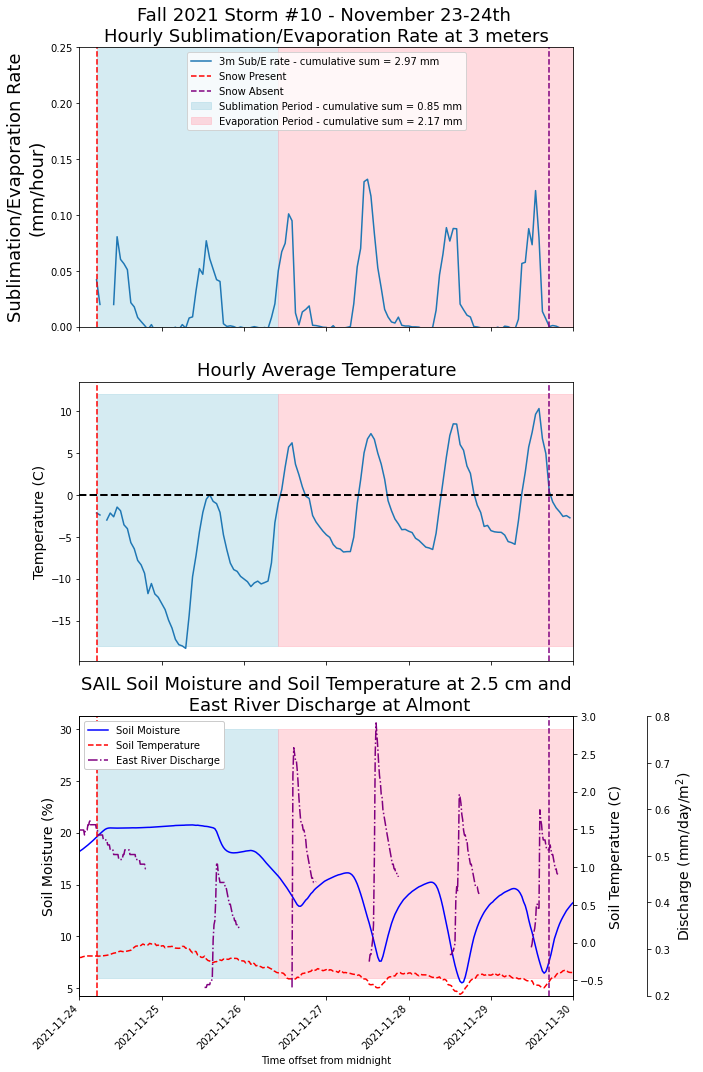

In [338]:
# Get latent heat of vaporization
Ls = 2.834e6
E_3m = df_tilden_1124_1130_3m['LE']/Ls * 3600 
E_10m = df_tilden_1124_1130_10m['LE']/Ls * 3600

fig, axs = plt.subplots(3, figsize=(10,15), tight_layout=True, facecolor='white', sharex=True)

# Plots for sublimation/evaporation rate
axs[0].plot(df_tilden_1124_1130_3m.index, E_3m, label=f'3m Sub/E rate - cumulative sum = {round(E_3m.sum(),2)} mm')

# Plots for air temperature and solar radiation
axs[1].plot(df_tilden_1124_1130_3m.index, df_tilden_1124_1130_3m['Tair']-273.15, label='3m Temperature')
axs[1].axhline(0, ls='--', color='k', lw=2)

# Plots for soil moisture and soil temperature
ax2_2 = axs[2].twinx()
ds_sebs_1124_1130['soil_temp_3'].plot(ax=ax2_2, label='Soil Temperautre', ls='--', color='r')
ds_sebs_1124_1130['soil_moisture_3'].where(ds_sebs_1124_1130['qc_soil_moisture_3']==0).plot(ax=axs[2], label='Soil Moisture',color='blue')
ax2_2.set_ylim(-0.7,3)
ax2_2.set_ylabel('Soil Temperature (C)', size=14)

ax2_3 = axs[2].twinx()
ax2_3.spines.right.set_position(("axes", 1.15))
ax2_3.plot(er_to_ph_q_2_mm.index,er_to_ph_q_2_mm, ls='-.', color='purple')
ax2_3.set_ylabel('Discharge (mm/day/m$^2$)', size=14)
ax2_3.set_ylim(0.2,0.8)

axs[2].plot([],[],label='Soil Temperature', ls='--', color='r')
axs[2].plot([],[],label='East River Discharge', ls='-.', color='purple')
axs[2].legend(loc='upper left',framealpha=1)
y_ranges = [[0,0.25],[-18,12],[6,30]]
for i,ax in enumerate(axs):
    ax.axvline(dt.datetime(2021,11,24,5), label='Snow Present', ls='--', color='red')
    ax.axvline(dt.datetime(2021,11,29,17), label='Snow Absent', ls='--', color='purple')
    ax.fill_betweenx(y_ranges[i], dt.datetime(2021,11,24,5),
                                  dt.datetime(2021,11,26,10), 
                                  label=f'Sublimation Period - cumulative sum = {round(E_3m.loc[dt.datetime(2021,11,24,5):dt.datetime(2021,11,26,10)].sum(),2)} mm', 
                                  alpha=0.5, 
                                  color='lightblue')
    ax.fill_betweenx(y_ranges[i], dt.datetime(2021,11,26,10),
                                  dt.datetime(2021,11,30,0), 
                                  label=f'Evaporation Period - cumulative sum = {round(E_3m.loc[dt.datetime(2021,11,26,10):dt.datetime(2021,11,30,0)].sum(),2)} mm', 
                                  alpha=0.5,
                                  color='lightpink')
    ax.tick_params(axis='x', rotation=45)
    if i ==0:
        ax.legend()
        ax.set_ylim(0,0.25)
    ax.set_xlim(dt.datetime(2021,11,24), dt.datetime(2021,11,30,0))

axs[0].set_ylabel('Sublimation/Evaporation Rate\n(mm/hour)', size=18)
axs[0].set_title('Fall 2021 Storm #10 - November 23-24th \nHourly Sublimation/Evaporation Rate at 3 meters', size=18)

axs[1].set_title('Hourly Average Temperature', size=18)
axs[1].set_ylabel('Temperature (C)', size=14)

axs[2].set_title('SAIL Soil Moisture and Soil Temperature at 2.5 cm and\n East River Discharge at Almont', size=18)
axs[2].set_ylabel('Soil Moisture (%)', size=14)